In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import deepwave as dw

In [2]:
device = 'cuda'

In [3]:
nx = 128
ny = 32
dx = 5.

vp_init, vs_init, rho_init = 1500, 1000, 2200

vp_background = torch.ones(ny, nx, device=device) * vp_init
vs_background = torch.ones(ny, nx, device=device) * vs_init
rho_background = torch.ones(ny, nx, device=device) * rho_init

In [69]:
vp_true = vp_background.clone()
vp_true[-10:] = 1400
vs_true = vs_background.clone()
vs_true[-20:] = 900
rho_true = rho_background.clone()
rho_true[:10] = 2300
rho_true[10:20] = 2500
rho_true[20:] = 2700

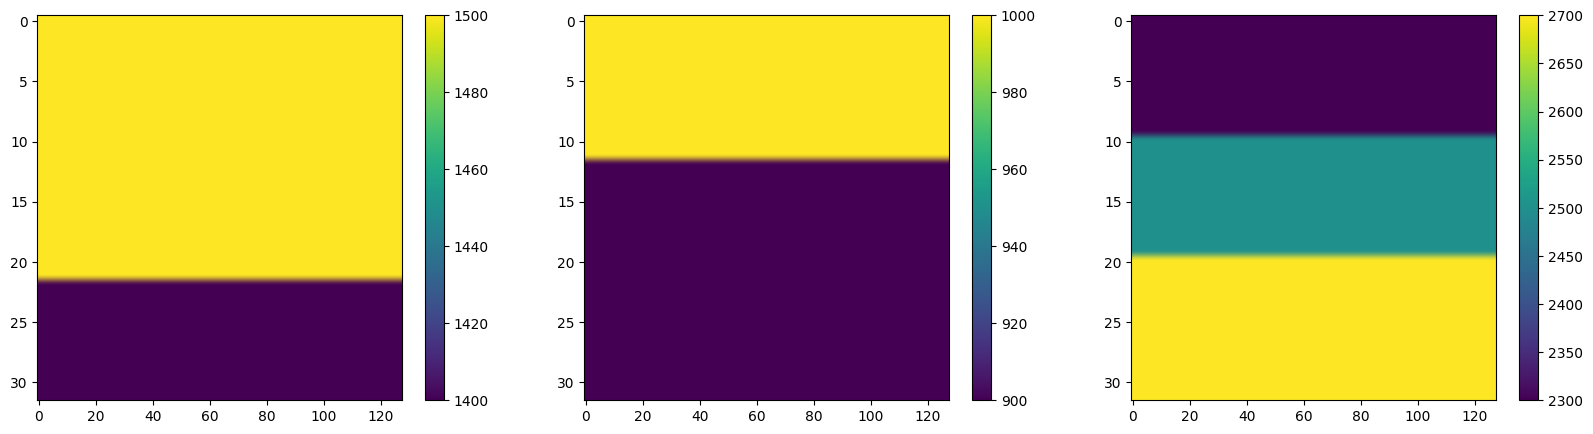

In [70]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
plt.colorbar(ax[0].imshow(vp_true.cpu(), aspect='auto'))
plt.colorbar(ax[1].imshow(vs_true.cpu(), aspect='auto'))
plt.colorbar(ax[2].imshow(rho_true.cpu(), aspect='auto'))
plt.show()

In [71]:
n_shots = 8
n_sources_per_shot = 1
d_source = 12 
first_source = 8
source_depth = 2

n_receivers_per_shot = nx-1
d_receiver = 1
first_receiver = 0
receiver_depth = 2

In [72]:
freq = 15
nt = 200
dt = 0.004
peak_time = 1.5 / freq

In [73]:
source_locations = torch.zeros(n_shots, n_sources_per_shot, 2, dtype=torch.float32, device=device)
source_locations[..., 0] = source_depth
source_locations[:, 0, 1] = (torch.arange(n_shots) * d_source + first_source)

In [74]:
receiver_locations = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.float32, device=device)
receiver_locations[..., 0] = receiver_depth
receiver_locations[:, :, 1] = (torch.arange(n_receivers_per_shot) * d_receiver + first_receiver).repeat(n_shots, 1)

In [75]:
source_amplitudes = (dw.wavelets.ricker(freq, nt, dt, peak_time)).repeat(n_shots, n_sources_per_shot, 1).to(device)

In [76]:
observed_data = dw.elastic(*dw.common.vpvsrho_to_lambmubuoyancy(vp_true, vs_true, rho_true), dx, dt,
                        source_amplitudes_y=source_amplitudes,
                        source_locations_y=source_locations,
                        receiver_locations_x=receiver_locations,
                        receiver_locations_y=receiver_locations,
                        pml_width=[0, 20, 20, 20]
)[-1]

In [77]:
observed_data.shape

torch.Size([8, 127, 200])

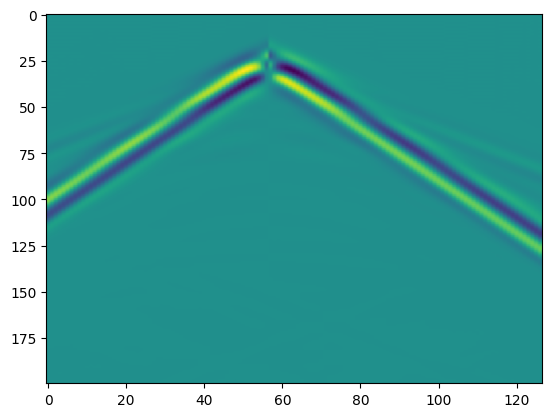

In [78]:
plt.imshow(observed_data[4].cpu().T, aspect='auto')

In [79]:
vp_lbfgs = vp_background.clone().requires_grad_()
vs_lbfgs = vs_background.clone().requires_grad_()
rho_lbfgs = rho_background.clone().requires_grad_()
optimiser = optim.LBFGS([vp_lbfgs, vs_lbfgs, rho_lbfgs])
loss_fn = nn.MSELoss()

n_epochs = 40

for epoch in (pbar:=tqdm(range(n_epochs))):
    def closure():
        optimiser.zero_grad()
        out = dw.elastic(
            *dw.common.vpvsrho_to_lambmubuoyancy(vp_lbfgs, vs_lbfgs, rho_lbfgs),
            dx, dt,
            source_amplitudes_y=source_amplitudes,
            source_locations_y=source_locations,
            receiver_locations_x=receiver_locations,
            receiver_locations_y=receiver_locations,
            pml_width=[0, 20, 20, 20]
        )[-1]
        loss = 1e20*loss_fn(out, observed_data)
        loss.backward()
        pbar.set_description(f"Epoch {epoch} - Loss: {loss.item():5e}")
        return loss

    optimiser.step(closure)

  0%|          | 0/20 [00:00<?, ?it/s]

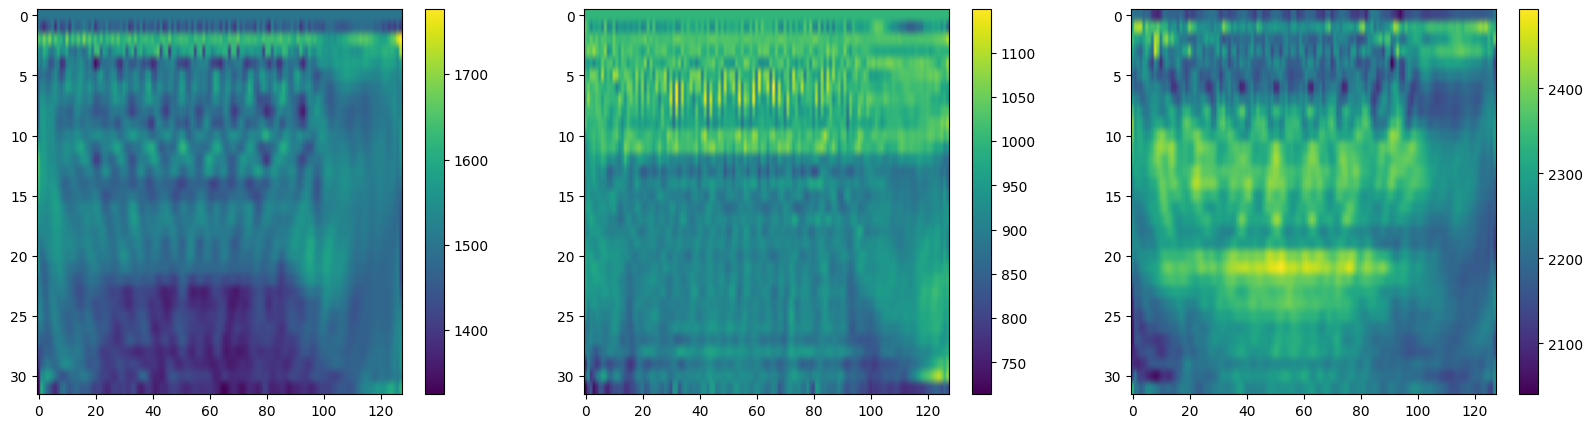

In [82]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
plt.colorbar(ax[0].imshow(vp_lbfgs.detach().cpu(), aspect='auto'))
plt.colorbar(ax[1].imshow(vs_lbfgs.detach().cpu(), aspect='auto'))
plt.colorbar(ax[2].imshow(rho_lbfgs.detach().cpu(), aspect='auto'))
plt.show()